AUGMENTATION

In [38]:
import pandas as pd
import numpy as np

# Load your existing dataset
df = pd.read_csv('/content/dataset.csv')

# Convert Bandwidth and Latency values as before
def convert_bandwidth_to_kbps(bandwidth):
    bandwidth = bandwidth.strip().upper()
    if ' KBPS' in bandwidth:
        return float(bandwidth.replace(' KBPS', ''))
    elif ' MBPS' in bandwidth:
        return float(bandwidth.replace(' MBPS', '')) * 1024
    elif ' KB' in bandwidth:
        return float(bandwidth.replace(' KB', ''))
    elif ' MB' in bandwidth:
        return float(bandwidth.replace(' MB', '')) * 1024
    else:
        raise ValueError(f"Unrecognized bandwidth unit in '{bandwidth}'")

def convert_latency_to_ms(latency):
    latency = latency.strip().upper()
    if ' MS' in latency:
        return float(latency.replace(' MS', ''))
    elif ' S' in latency:
        return float(latency.replace(' S', '')) * 1000
    else:
        raise ValueError(f"Unrecognized latency unit in '{latency}'")

# Apply conversion
df['Required_Bandwidth'] = df['Required_Bandwidth'].apply(convert_bandwidth_to_kbps)
df['Allocated_Bandwidth'] = df['Allocated_Bandwidth'].apply(convert_bandwidth_to_kbps)
df['Latency'] = df['Latency'].apply(convert_latency_to_ms)

# Calculate min and max ranges for each application type
ranges_by_app = df.groupby('Application_Type').agg({
    'Latency': ['min', 'max'],
    'Required_Bandwidth': ['min', 'max'],
    'Allocated_Bandwidth': ['min', 'max']
}).reset_index()

# Flatten column names
ranges_by_app.columns = ['_'.join(col).strip() for col in ranges_by_app.columns.values]
ranges_by_app.rename(columns={'Application_Type_': 'Application_Type'}, inplace=True)

def generate_within_range(app_type, num_samples, ranges_by_app):
    ranges = ranges_by_app[ranges_by_app['Application_Type'] == app_type].iloc[0]

    latency_min = ranges['Latency_min']
    latency_max = ranges['Latency_max']
    bandwidth_req_min = ranges['Required_Bandwidth_min']
    bandwidth_req_max = ranges['Required_Bandwidth_max']
    bandwidth_alloc_min = ranges['Allocated_Bandwidth_min']
    bandwidth_alloc_max = ranges['Allocated_Bandwidth_max']

    data = {
        'Latency': np.random.uniform(latency_min, latency_max, num_samples),
        'Required_Bandwidth': np.random.uniform(bandwidth_req_min, bandwidth_req_max, num_samples),
        'Allocated_Bandwidth': np.random.uniform(bandwidth_alloc_min, bandwidth_alloc_max, num_samples)
    }

    return pd.DataFrame(data)

# Generate new data for each application type
app_types = df['Application_Type'].unique()
num_samples_per_type = (15000 - len(df)) // len(app_types)

new_data_frames = []
for app_type in app_types:
    new_df = generate_within_range(app_type, num_samples_per_type, ranges_by_app)
    new_df['Application_Type'] = app_type
    new_data_frames.append(new_df)

# Combine original data with new data
new_df = pd.concat(new_data_frames, ignore_index=True)
augmented_df = pd.concat([df, new_df], ignore_index=True)

# Save the augmented dataset
augmented_df.to_csv('/content/augmented_dataset.csv', index=False)


PREPROCESSING

In [48]:
import pandas as pd

# Load the augmented dataset
augmented_df = pd.read_csv('/content/augmented_dataset.csv')

# 1. Remove the Signal_Strength column if it exists
if 'Signal_Strength' in augmented_df.columns:
    augmented_df.drop('Signal_Strength', axis=1, inplace=True)

# 2. Clean User_ID column to retain only numeric part
# Extract numeric part and fill NaNs with a placeholder value (e.g., -1)
augmented_df['User_ID'] = augmented_df['User_ID'].str.extract('(\d+)').astype(float)
augmented_df['User_ID'].fillna(-1, inplace=True)
augmented_df['User_ID'] = augmented_df['User_ID'].astype(int)

# 3. Calculate Efficiency by Application_Type
def calculate_efficiency(df):
    # Group by Application_Type and calculate max values within each group
    max_values = df.groupby('Application_Type').agg({
        'Latency': 'max',
        'Allocated_Bandwidth': 'max'
    }).reset_index()

    # Merge max values back to the original dataframe
    df = df.merge(max_values, on='Application_Type', suffixes=('', '_max'))

    # Calculate Efficiency (allowing values to exceed 100)
    df['Efficiency'] = 100 - (df['Latency'] / df['Latency_max']) * 100 + (df['Allocated_Bandwidth'] / df['Allocated_Bandwidth_max']) * 100

    # Drop the temporary max columns
    df.drop(['Latency_max', 'Allocated_Bandwidth_max'], axis=1, inplace=True)

    return df

# Apply the efficiency calculation
augmented_df = calculate_efficiency(augmented_df)

# Save the preprocessed dataset
augmented_df.to_csv('/content/preprocessed_augmented_dataset.csv', index=False)


VISUALISATION

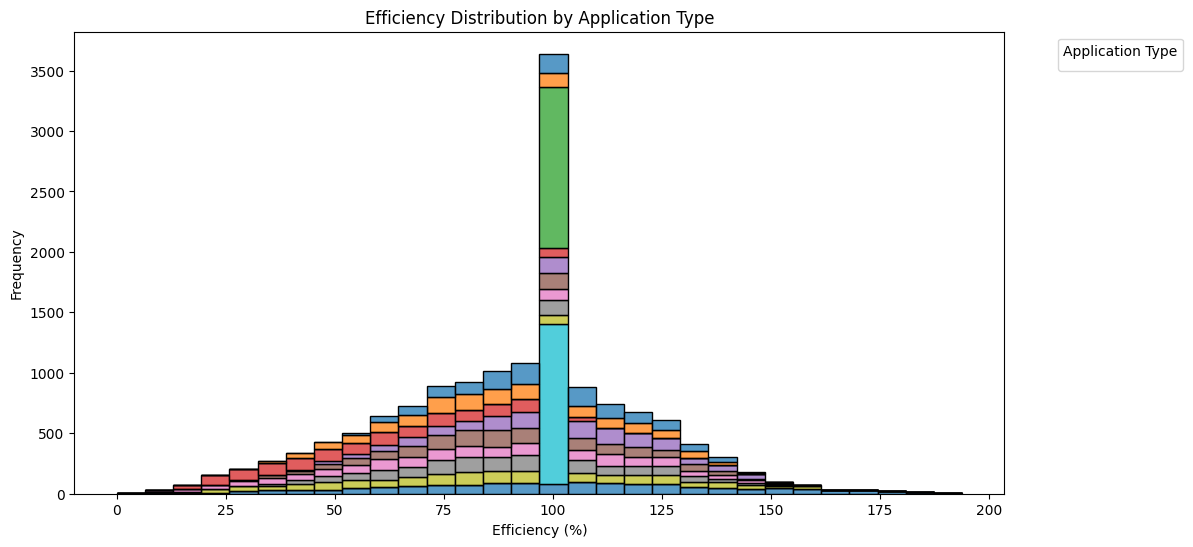

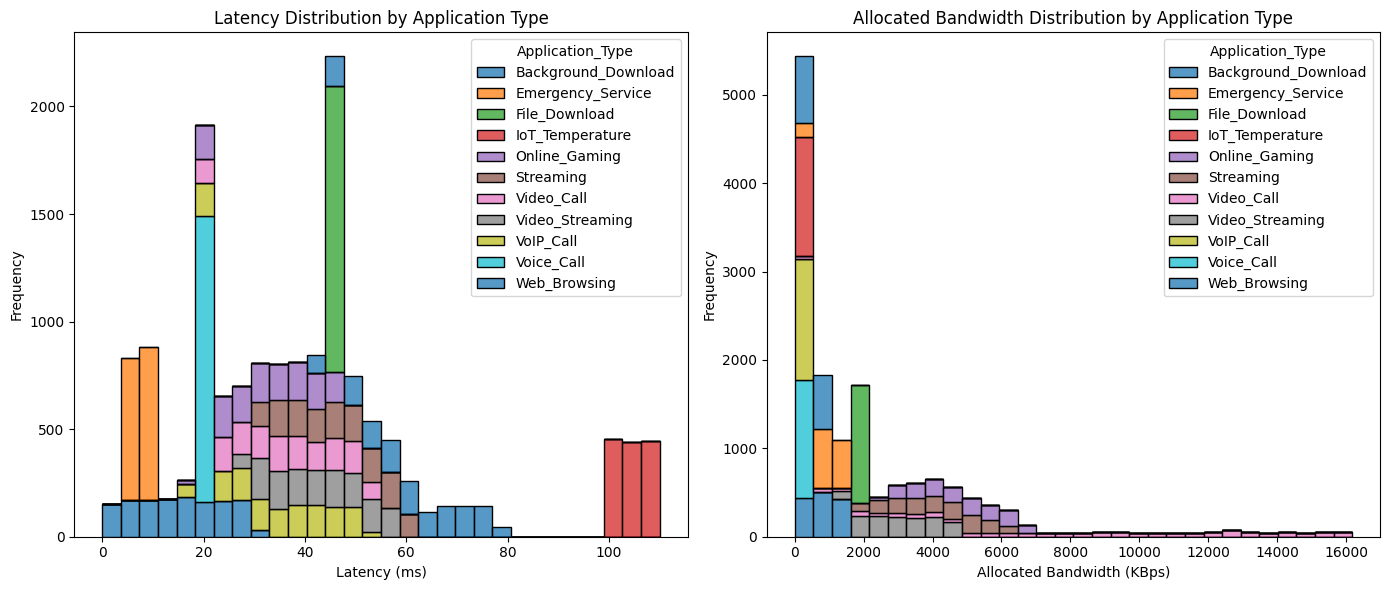

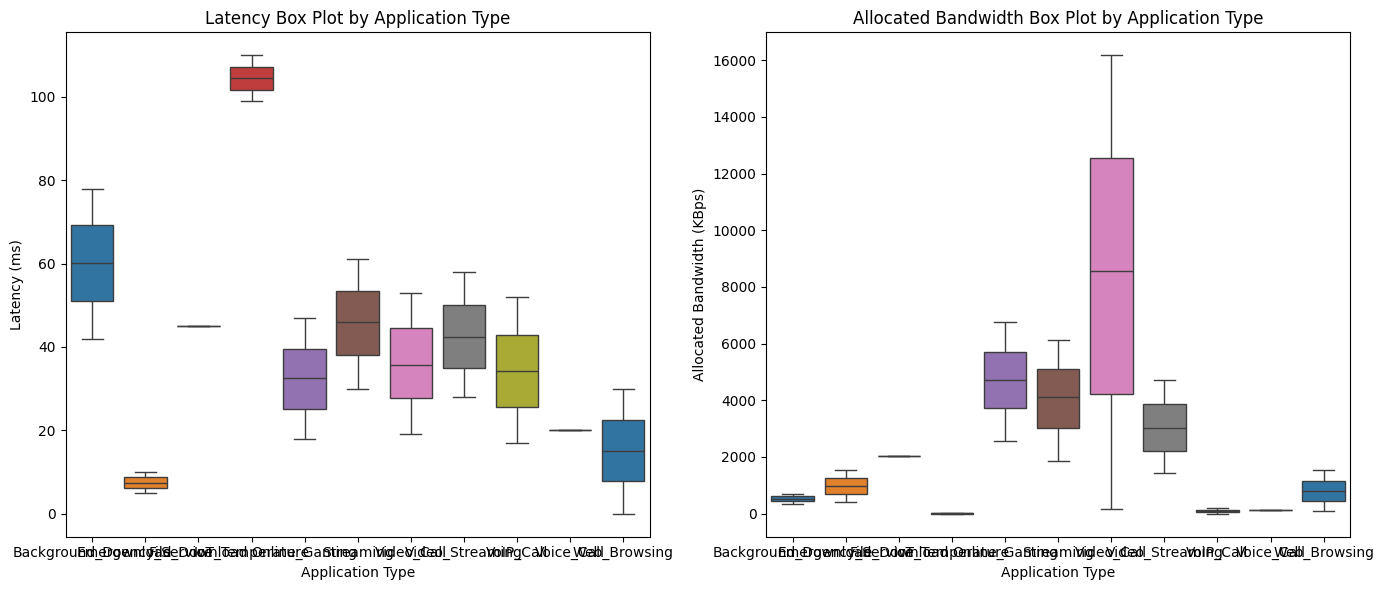

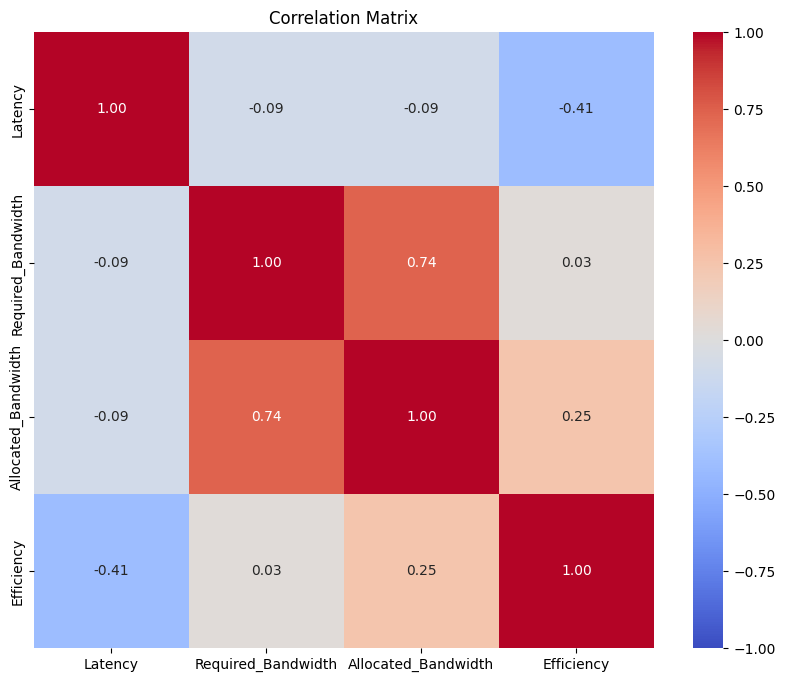

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('/content/preprocessed_augmented_dataset.csv')

# Ensure Application_Type column is of type 'category' for better plotting
df['Application_Type'] = df['Application_Type'].astype('category')

# Create a color palette for each application type
palette = sns.color_palette("tab10", n_colors=len(df['Application_Type'].cat.categories))

# 5. Plot Efficiency Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Efficiency', hue='Application_Type', multiple='stack', palette=palette, bins=30)
plt.title('Efficiency Distribution by Application Type')
plt.xlabel('Efficiency (%)')
plt.ylabel('Frequency')
plt.legend(title='Application Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 6. Plot Feature Distribution
# Latency
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Latency', hue='Application_Type', multiple='stack', palette=palette, bins=30)
plt.title('Latency Distribution by Application Type')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')

# Allocated Bandwidth
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='Allocated_Bandwidth', hue='Application_Type', multiple='stack', palette=palette, bins=30)
plt.title('Allocated Bandwidth Distribution by Application Type')
plt.xlabel('Allocated Bandwidth (KBps)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 7. Box plots for latency and allocated bandwidth
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Application_Type', y='Latency', hue='Application_Type', palette=palette)
plt.title('Latency Box Plot by Application Type')
plt.xlabel('Application Type')
plt.ylabel('Latency (ms)')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Application_Type', y='Allocated_Bandwidth', hue='Application_Type', palette=palette)
plt.title('Allocated Bandwidth Box Plot by Application Type')
plt.xlabel('Application Type')
plt.ylabel('Allocated Bandwidth (KBps)')

plt.tight_layout()
plt.show()

# 8. Correlation Matrix
corr_matrix = df[['Latency', 'Required_Bandwidth', 'Allocated_Bandwidth', 'Efficiency']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
